In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 


#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom
from skimage.restoration import denoise_tv_chambolle
import bm3d 

#Plug and Pla
import pnp_mace as pnpm
from dotmap import DotMap

# Test image
phantom = shepp_logan_phantom()
num_scans = 180
angles = np.linspace(0., 360, num_scans, endpoint=False)
phantom_resized = resize(phantom, (200, 200), mode='reflect')

#Forward model (Radon transform) and FBP inversion
def A(x):
    angles = np.linspace(0., 360, num_scans, endpoint=False)
    return radon(x, theta=angles, circle=True)

def AT(x):
    angles = np.linspace(0., 360, num_scans, endpoint=False)
    return iradon(x, theta=angles, circle=True)

#Denoiser for the prior - can use any
def denoiser(x, params):
    denoised_x = denoise_tv_chambolle(x, weight=params.noise_std)
    return denoised_x


#Peak signal to noise ratio
def PSNR(original, img, max_value = 255): 
    mse = np.mean((np.array(original, dtype=np.float32) - np.array(img, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

# Forward model (Radon transform)

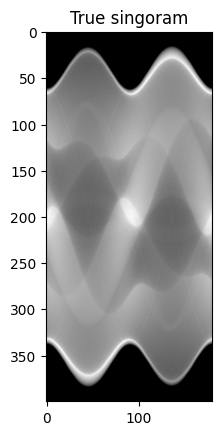

In [2]:

sinogram = A(phantom)

# Display the sinogram
plt.title('True singoram')
plt.imshow(sinogram, cmap='gray')



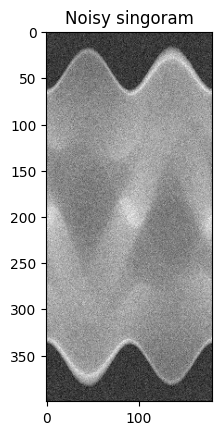

In [3]:
#Noisy sinogram

noise = 9 * np.random.standard_normal(sinogram.shape)

noisy_sinogram = sinogram + noise
plt.title('Noisy singoram')
plt.imshow(noisy_sinogram, cmap='gray')

# Filter back-projection (FBP) - inversion

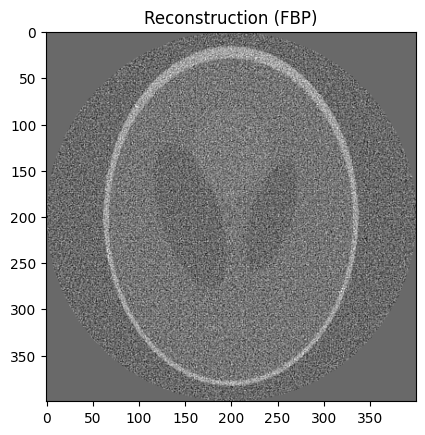

In [4]:
#FBP reconstruction
fbp_recon = iradon(sinogram, theta=angles, circle=True)
fbp_noisy_recon = iradon(noisy_sinogram, theta=angles, circle=True)

plt.title('Reconstruction (FBP)')
plt.imshow(fbp_noisy_recon, cmap='gray')

# Plug-and-play (PnP) regularisation method

Uses the FBP step and then denoises it

In [101]:
#parameters
step_size = 0.9

# Forward agent (data fidelity term) that uses the A- radon and AT - FBP
forward_agent = pnpm.LinearProxForwardAgent(noisy_sinogram, A, AT, step_size)

In [102]:
#prior 
def prior_agent_method(x, params):
    denoised_x = denoiser(x, params)
    return denoised_x

prior_params = DotMap()
prior_params.noise_std = step_size

prior_agent = pnpm.PriorAgent(prior_agent_method, prior_params)


In [103]:
#display results function

def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        
        #cur_min = np.round(np.amin(img), 1)
        #cur_max = np.round(np.amax(img), 1)
        #bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        #psnr = PSNR(ground_truth, img)
        #titles.append(title + ' [PSNR: ' + str(psnr) + ']')

        nrmse = pnpm.nrmse(img, ground_truth)
        titles.append(title + ' [NRMSE: ' + str(nrmse) + ']')

    for img, title in zip(image_list, titles):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 5))
        

        ax.imshow(img, cmap='gray')
        #pnpm.display_image(img, fig=fig, ax=ax, cmap='gray')

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()


In [104]:
one_step_forward = forward_agent(np.asarray(fbp_noisy_recon))
one_step_prior = prior_agent(np.asarray(fbp_noisy_recon))

display_images([one_step_forward, one_step_prior], ['One step of forward model', 'One step of prior model'], phantom)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 400 is different from 7056)

In [ ]:
mu0 = 0.1 #forward weight
num_iters = 10
mu = [mu0, 1 - mu0]
rho = 0.1
keep_all_images = False

equil_params = DotMap()
equil_params.mu = mu
equil_params.rho = rho
equil_params.num_iters = num_iters
equil_params.keep_all_images = keep_all_images
equil_params.verbose = True

agents = [forward_agent, prior_agent]
#MACE setup
equil_prob = pnpm.EquilibriumProblem(agents, pnpm.mann_iteration_mace,
                                      equil_params)

init_images = pnpm.stack_init_image(fbp_noisy_recon, len(agents))

In [ ]:
final_images, residuals, vectors, all_images = equil_prob.solve(
    init_images)


Starting Mann iterations
Finished iteration 1 of 10
Finished iteration 2 of 10


c:\Users\as5057\OneDrive - University of Bath\1st Year\TfR\.venv\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Finished iteration 3 of 10
Finished iteration 4 of 10
Finished iteration 5 of 10
Finished iteration 6 of 10
Finished iteration 7 of 10
Finished iteration 8 of 10
Finished iteration 9 of 10
Finished iteration 10 of 10


C:\Users\as5057\AppData\Local\Temp\ipykernel_23488\3640556878.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


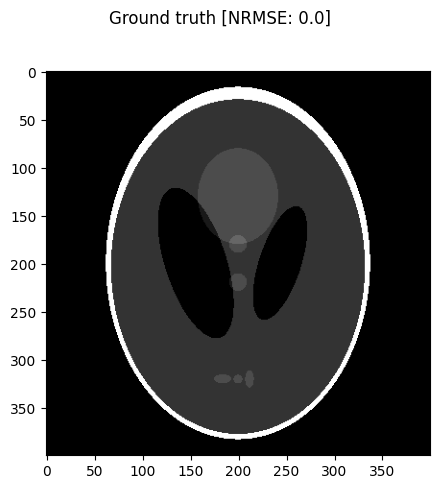

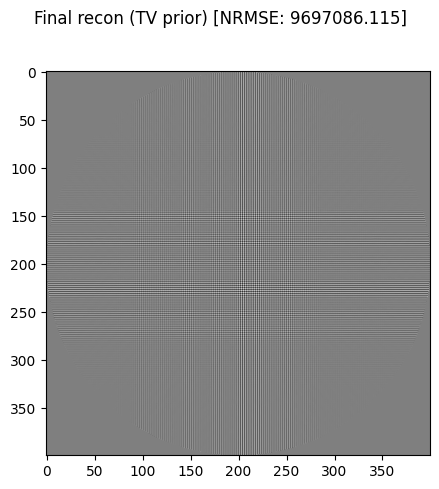

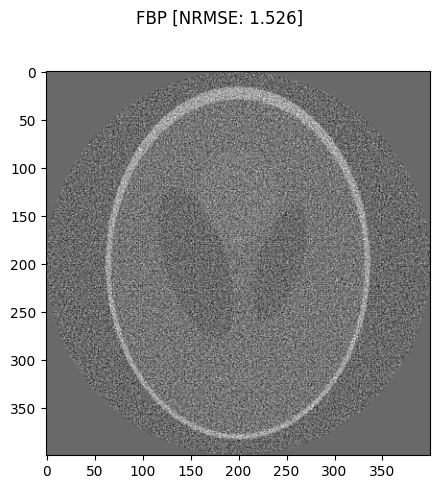

In [ ]:
p = shepp_logan_phantom()
im = final_images[0]
display_images([p, im, fbp_noisy_recon], ['Ground truth', 'Final recon (TV prior)', 'FBP'], p)

# Block matching 3D (BM3D) denoiser

In [ ]:
prior_agent2 = pnpm.PriorAgent(bm3d.bm3d, prior_params)
prior_agent2(np.asarray(fbp_noisy_recon))

C:\Users\as5057\AppData\Local\Temp\ipykernel_23488\3640556878.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


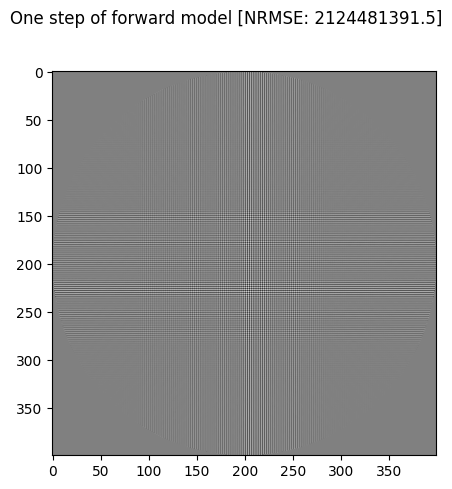

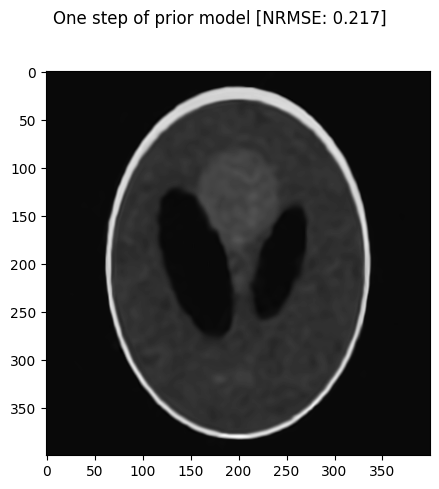

In [13]:
# first iterate
one_step_prior1 = pnpm.prioragent.bm3d(fbp_noisy_recon, 0.9)
one_step_forward1 = forward_agent(np.asarray(fbp_noisy_recon))
#one_step_prior = prior_agent(np.asarray(fbp_noisy_recon))

display_images([one_step_forward1, one_step_prior1], ['One step of forward model', 'One step of prior model'], p)

# Base PnP-ADMM with usual denoisers (Discretised Radon transform)

In [14]:
#Discretised version with A
n = 84

circle = False
n_angles = 60
theta = np.linspace(0., 180.,n_angles, endpoint=False)
sigma = 100e-1
size = (radon(np.zeros((n,n)), theta=theta, circle = circle)).shape
M = size[0]*size[1]
A = np.zeros((M, n**2))
for i in range(n**2):
    e = np.zeros((n**2,))
    e[i]=1
    e = np.reshape(e,(n,n))
    sinogram = radon(e, theta=theta, circle = circle)
    A[:,i] = np.reshape(sinogram[:], (M,))

# Load the Shepp-Logan phantom
phantom = resize(shepp_logan_phantom(), (n,n))



(7140, 7056)

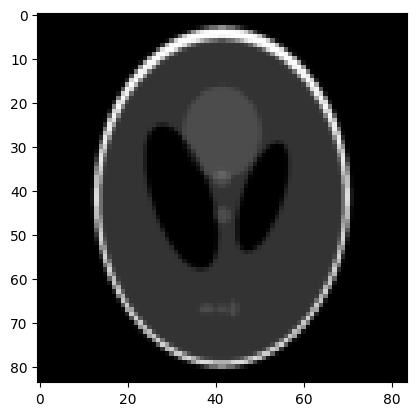

In [15]:
#ground truth
x = phantom.reshape(-1)

plt.imshow(phantom, cmap='gray')
A.shape

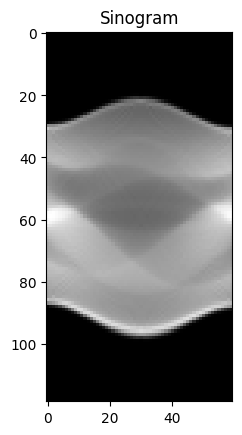

In [16]:
#b
clean_sinogram_flattened = A@x.flatten()
b = clean_sinogram_flattened + np.random.normal(0,1,7140)

y = np.reshape(A@x, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')

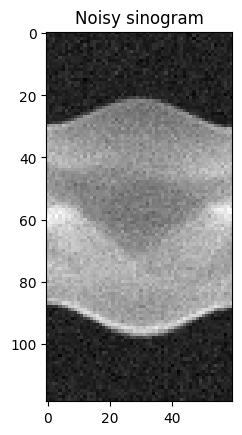

In [17]:
#noisy sinogram
plt.title("Noisy sinogram")
s = np.reshape(b, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.imshow(s, cmap='gray')

Text(0.5, 1.0, 'FBP reconstruction')

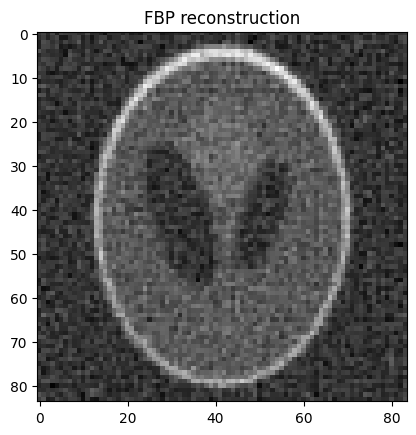

In [18]:
reconstruction_fbp = iradon(s, theta=theta, filter_name='ramp', circle=False)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('FBP reconstruction')

## Denoisers (TV, BM3D, K-SVD)

In [19]:
from bm3d import bm3d
from sklearn.feature_extraction import image

def ksvd_denoise(x):
    patches = image.extract_patches_2d(x, (8,8))
    


In [21]:
from tqdm import tqdm

def pnp_admm(A, b, x_ground_truth, denoiser, rho = 0.1, niter = 20):
    """
    Alternating directions method of multiplers with different denoisers to use  
    """ 

    def apply_denoiser(x, method):
        """
        Denoiser options for the u step (replacing the proximal operator)
        """
        if method == 'tv':
            return denoise_tv_chambolle(x, weight = 0.3)
        elif method == 'bm3d':
            return bm3d(x, sigma_psd = 5.9)
        elif method == 'proximal':
            return np.sign(x)*np.maximum(0, x)
        

    def nrmse(x, x_ground_truth):
        """
        Normalised root mean square error between final prediction and ground truth image
        """
        return np.linalg.norm(x - x_ground_truth)/np.linalg.norm(x_ground_truth)

    
    #dimensions
    n = int(np.sqrt(A.shape[1]))
    #defining the 3 variables for use
    x = np.zeros_like(x_ground_truth)
    u = np.zeros_like(x_ground_truth)
    v = np.zeros_like(x_ground_truth)
    metric_list = []

    #PnP ADMM iteration performed on the 3 variables
    for i in tqdm(range(niter), desc = 'PnP ADMM iterations'):
        
        #FBP inversion
        measurement = np.reshape(b, (int(np.ceil(n*np.sqrt(2))), n_angles))
        correction = np.reshape(A@(rho*(u - v)), (int(np.ceil(n*np.sqrt(2))), n_angles))
        fbp = measurement + correction
        x = iradon(fbp, theta= theta, filter_name='ramp', circle=False)
        #x = np.linalg.solve(A.T @ A + rho * np.eye(A.shape[1]), A.T @ b + rho * (u - v))

        # reshaping u and v for the denoiser (1D to 2D)
        u = u.reshape((n, n))
        v = v.reshape((n, n))
        u = apply_denoiser(x + v, denoiser)
        v += x - u

        #flattening u and v for the next iteration when applying FBP (2D to 1D)
        u = u.flatten()
        v = v.flatten()


        #psnr = PSNR(x_ground_truth, x.flatten())
        #print("current PSNR:", psnr)

        current_nrmse = nrmse(x.flatten(), x_ground_truth)
        metric_list.append(current_nrmse)

        

    return x, metric_list



In [22]:
result_tv, metrics_tv = pnp_admm(A, b, x, 'tv', niter = 50)
result_bm3d, metrics_bm3d = pnp_admm(A, b, x, 'bm3d', niter = 50)

PnP ADMM iterations: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [97]:
result_proximal, metrics_prox = pnp_admm(A, b, x, 'proximal', niter = 50)

PnP ADMM iterations: 100%|██████████| 50/50 [00:01<00:00, 33.15it/s]


C:\Users\as5057\AppData\Local\Temp\ipykernel_20264\3640556878.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


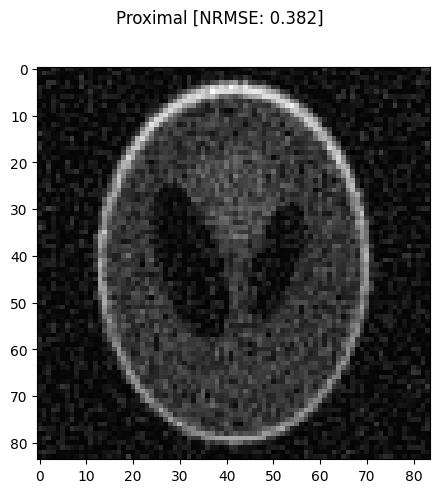

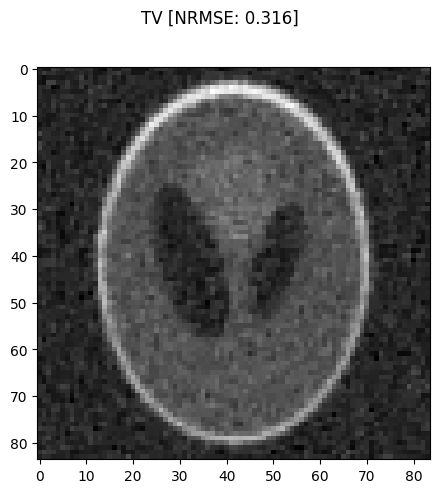

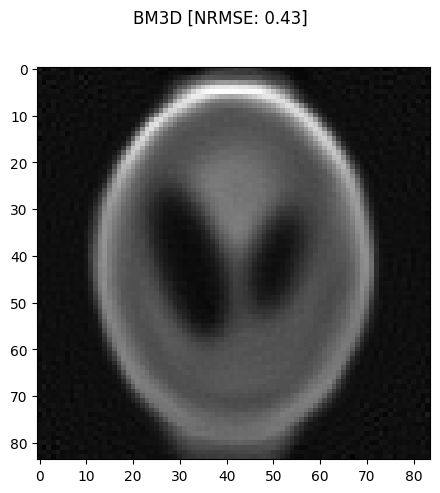

In [98]:
display_images([result_proximal ,result_tv, result_bm3d], ['Proximal','TV', 'BM3D'], phantom)

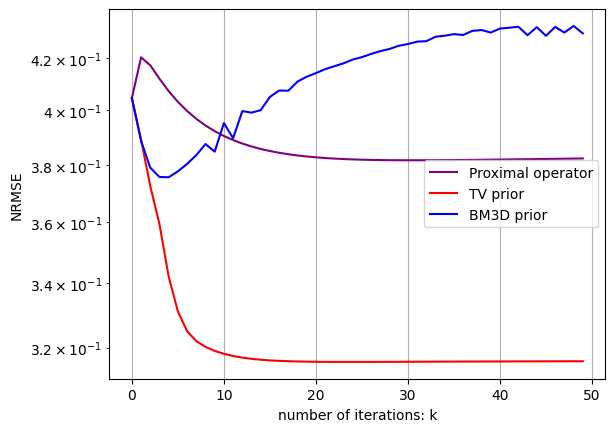

In [99]:
def comparison_plot(norm_res, method, ytitle='NRMSE', color='k'):
    K = len(norm_res)

    plt.semilogy(norm_res, color=color, label=method)
    k = np.arange(K)

    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid(True)

comparison_plot(metrics_prox, 'Proximal operator', color='purple')
comparison_plot(metrics_tv, 'TV prior', color='red')
comparison_plot(metrics_bm3d, 'BM3D prior', color='blue')

# Forward-backward splitting (FBS/PGD)


In [90]:
#ISTA
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def denoiser(x, l, method):
        """
        Denoiser options for the u step (replacing the proximal operator)
        """
        L = np.linalg.norm(A) ** 2  # Lipschitz constant
        if method == 'tv':
            return denoise_tv_chambolle(x, weight = 0.3)
        elif method == 'bm3d':
            return bm3d(x, sigma_psd = 5.9)
        elif method == 'proximal':
            return soft_thresh(x, l/L)


def pnp_ista(A, b, x_truth, method, l, iters, tol = 1e-3):
    """
    
    PnP iterative shrinkage thrseholding algorithm (PnP-FISTA)
    """
    x = np.zeros(A.shape[1])
    minimisations = []
    relative = []
    L = np.linalg.norm(A) ** 2  # Lipschitz constant
    for i in range(iters):
        #gradient descent step
        grad_g = A.T @ (A @ x - b)
        x_descent = x - (grad_g/ L)

        #denoising step
        x = denoiser(x_descent, l, method)
        #x = soft_thresh(x_descent, l / L)


        current_min = 0.5 * np.linalg.norm(A.dot(x) - b) ** 2 + l * np.linalg.norm(x, 1)
        minimisations.append(current_min)
        diff = np.linalg.norm(x - x_truth)/np.linalg.norm(x_truth)
        relative.append(diff)
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, np.linalg.norm(grad_g), tol))
            break
    return x, relative, minimisations


def pnp_fista(A, b, x_g, l, iters, tol = 1e-3):
    """
    PnP FISTA (accelerated PGD)
    """
    ground = 0.5 * np.linalg.norm(A.dot(x_g) - b) ** 2 + l * np.linalg.norm(x_g, 1)
    x = np.zeros(A.shape[1])
    gs = []
    relative = []
    t = 1
    z = x.copy()
    L = np.linalg.norm(A) ** 2
    for i in range(iters):
        grad_g = A.T @ (A @ x - b)
        xold = x.copy()
        z = z + A.T.dot(b - A.dot(z)) / L
        x = soft_thresh(z, l / L)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        current_g = 0.5 * np.linalg.norm(A.dot(x) - b) ** 2 + l * np.linalg.norm(x, 1)
        gs.append(current_g)
        diff = np.linalg.norm(x - x_g)/np.linalg.norm(x_g)
        relative.append(diff)
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(k, np.linalg.norm(grad_g), tol))
            break
        if i == 1:
          Xone = x
        elif i == 250:
          X250 = x

    return x, Xone, X250, relative, gs





def plot_and_estimate_convergence(norm_res, method, ytitle, color='k'):
    K = len(norm_res)

    plt.semilogy(norm_res, color=color, label=method)
    k = np.arange(K)

    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid()





In [98]:
x_ground_truth = x
x_final, relative, g = pnp_ista(A, b, x_ground_truth, 'proximal', 10, 500)
#x_final, relative, g = pnp_ista(A, b, x_ground_truth, 'tv', 0.1, 100)
#x_final, relative, g = pnp_ista(A, b, x_ground_truth, 'bm3d', 0.1, 100)

#x1, r1, g1 = pnp_ista(A, b, x_ground_truth, 1, 100)
#x2, r2, g2 = pnp_ista(A, b, x_ground_truth, 7, 100)

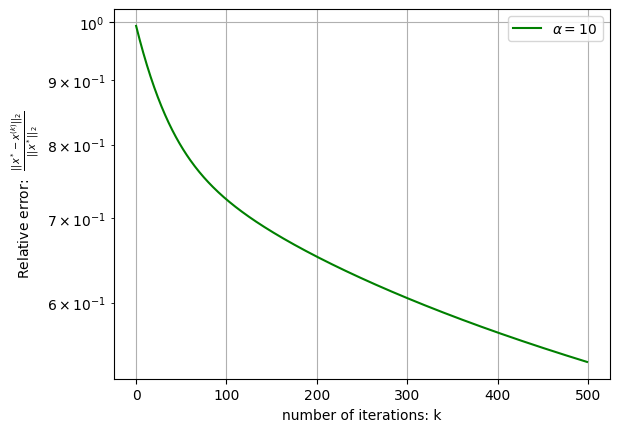

In [100]:
plot_and_estimate_convergence(relative, '$\\alpha = 10$','Relative error:  $\\frac{||x^* - x^{(k)}||_2}{||x^*||_2}$', color='green')
#plot_and_estimate_convergence(r1, '$\\alpha = 1$','Relative error:  $\\frac{||x^* - x^{(k)}||_2}{||x^*||_2}$', color='red')
#plot_and_estimate_convergence(r2, '$\\alpha = 7$','Relative error:  $\\frac{||x^* - x^{(k)}||_2}{||x^*||_2}$', color='purple')

In [43]:
from sklearn.model_selection import KFold

def grid_search_lambda(A, b, x_g, l_range, denoiser, iters=100, cv=5):
    """     
    Grid search for the optimal lambda using cross-validation
    """
    kf = KFold(n_splits=cv)
    best_lambda = None
    best_score = float('inf')

    for l in l_range:
        scores = []
        for train_index, val_index in kf.split(A):
            A_train, A_val = A[train_index], A[val_index]
            b_train, b_val = b[train_index], b[val_index]

            x, _, _ = pnp_ista(A_train, b_train, x_g, l, iters)
            val_error = np.linalg.norm(A_val.dot(x) - b_val) / np.linalg.norm(b_val)
            scores.append(val_error)

        mean_score = np.mean(scores)
        print(f'Lambda: {l:.4f}, Mean Validation Error: {mean_score:.4f}')
        if mean_score < best_score:
            best_score = mean_score
            best_lambda = l

    print(f'Best lambda: {best_lambda:.4f} with Mean Validation Error: {best_score:.4f}')
    return best_lambda


In [63]:
np.linspace(0.1, 500, 25)

array([1.00000000e-01, 2.09291667e+01, 4.17583333e+01, 6.25875000e+01,
       8.34166667e+01, 1.04245833e+02, 1.25075000e+02, 1.45904167e+02,
       1.66733333e+02, 1.87562500e+02, 2.08391667e+02, 2.29220833e+02,
       2.50050000e+02, 2.70879167e+02, 2.91708333e+02, 3.12537500e+02,
       3.33366667e+02, 3.54195833e+02, 3.75025000e+02, 3.95854167e+02,
       4.16683333e+02, 4.37512500e+02, 4.58341667e+02, 4.79170833e+02,
       5.00000000e+02])

In [64]:
lambda_range = np.linspace(0.1, 500, 25)
best_lambda = grid_search_lambda(A, b, x_ground_truth, lambda_range)

Lambda: 0.1000, Mean Validation Error: 0.7457
Lambda: 20.9292, Mean Validation Error: 0.7487
Lambda: 41.7583, Mean Validation Error: 0.7531
Lambda: 62.5875, Mean Validation Error: 0.7590
Lambda: 83.4167, Mean Validation Error: 0.7665
Lambda: 104.2458, Mean Validation Error: 0.7757
Lambda: 125.0750, Mean Validation Error: 0.7864
Lambda: 145.9042, Mean Validation Error: 0.7981
Lambda: 166.7333, Mean Validation Error: 0.8099
Lambda: 187.5625, Mean Validation Error: 0.8216
Lambda: 208.3917, Mean Validation Error: 0.8334
Lambda: 229.2208, Mean Validation Error: 0.8451
Lambda: 250.0500, Mean Validation Error: 0.8567
Lambda: 270.8792, Mean Validation Error: 0.8684
Lambda: 291.7083, Mean Validation Error: 0.8801
Lambda: 312.5375, Mean Validation Error: 0.8917
Lambda: 333.3667, Mean Validation Error: 0.9030
Lambda: 354.1958, Mean Validation Error: 0.9138
Lambda: 375.0250, Mean Validation Error: 0.9241
Lambda: 395.8542, Mean Validation Error: 0.9339
Lambda: 416.6833, Mean Validation Error: 0.943

In [65]:
x_final, relative, g = ista(A, b, x_ground_truth, 0.1, 400)

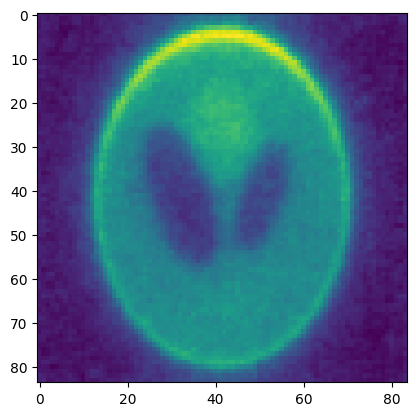

In [66]:
plt.imshow(x_final.reshape(n,n) )